In [1]:
using StatsBase, Distributions, PyPlot
include("mbsampler.jl") 

get_clustering_vec (generic function with 1 method)

In [2]:
# approximate the mean of sin evaluated over x 
N = 7
x = 1:N
mean(map(sin,x))

0.07910467860603455

In [3]:
# Set minibatch size
mb_size = 1000000

1000000

In [4]:
# Test uniform subsampling
gw = umbsampler(N,mb_size)
mbs_estimate(gw,sin,x)

0.07967403014636895

In [5]:
# Test weighted subsampling
w = [.1,.2,.3,.05,.05,.37,0.1]
w/=sum(w)
gw = wumbsampler(N,mb_size,w)
mbs_estimate(gw,sin,x)

0.07766917177217399

In [6]:
# Test grouped subsampling
w = [.1,.1,.2,.2,.05,.1,0.1]
w/=sum(w)
g = [1,1, -1,-1, -1,1,1]

mb_size = mb_size
gw = gmbsampler(mb_size,w,g)
mbs_estimate(gw,sin,x)

0.0788239844792748

In [7]:
# Test weighted subsampling
w = [.1,.2,.3,.05,.05,.37,0.1]
w/=sum(w)
gw = wumbsampler(N,mb_size,w)
mbs_estimate(gw,sin,x)

0.07870016011257522

In [8]:
# Test stratified/clustered subsampling
w = [.1,.1,.2,.2,.05,.1,0.1]
w/=sum(w)
N, = size(w)
x = 1:N

clusters = [[1,2,3,4],[5,6,7]]
scp = [mb_size/2,mb_size/2]

csamplers = Array{mbsampler}(2)
for (ci, c) in enumerate(clusters)
    csamplers[ci] = wumbsampler(size(c)[1], scp[ci], w[c])
end

gw = cmbsampler(csamplers, clusters)
gw.mb_table
mbs_estimate(gw,sin,x)

0.07826241692302788

In [9]:
typeof(clusters)

Array{Array{Int64,1},1}

In [10]:
cc = [[[1,2,3,4],[5,6,7]], [[1,2,3],[4,5,6,7]]]

2-element Array{Array{Array{Int64,1},1},1}:
 Array{Int64,1}[[1, 2, 3, 4], [5, 6, 7]]
 Array{Int64,1}[[1, 2, 3], [4, 5, 6, 7]]

In [11]:
cc[1][1]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [15]:
a_all = []
a = []
a2 = []
a=push!(a, Int[1])
a=push!(a, Int[2,3])
a = convert(Array{Array{Int64,1},1},a)
a2=push!(a2, Int[1])
a2=push!(a2, Int[1,3])
a2 = convert(Array{Array{Int64,1},1},a2)
print(g)
typeof(g)
a_all = push!(a_all, a) 
a_all = push!(a_all, a2) 
a_all

[1, 1, -1, -1, -1, 1, 1]

2-element Array{Any,1}:
 Array{Int64,1}[[1], [2, 3]]
 Array{Int64,1}[[1], [1, 3]]

In [13]:
a = []
a=push!(a, [1])
a=push!(a, [2,3]) 
for (i, e) in enumerate(a)
    a[i] = convert(Array{Float64,1}, e)
end
print(a)

Any[[1.0], [2.0, 3.0]]

In [14]:
convert(Array{Float64,1}, a)

LoadError: [91mMethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.[39m

In [15]:
my_stuff = zeros()
push!(my_stuff, "new element")

LoadError: [91mMethodError: no method matching push!(::Array{Float64,0}, ::String)[0m
Closest candidates are:
  push!(::Any, ::Any, [91m::Any[39m) at abstractarray.jl:1940
  push!(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at abstractarray.jl:1941
  push!([91m::Array{Any,1}[39m, ::ANY) at array.jl:658
  ...[39m

In [16]:
using PyPlot, TimeIt, Distributions, Optim
import PyPlot
const plt = PyPlot
include("ZZ_subsampling.jl")
include("ZZ_clustering.jl") 

ZZ_clustering (generic function with 6 methods)

In [17]:
function logistic_data(d, Nobs, β_true, px, py=0.1) 
    X = ones(d, Nobs)
    X[2:end,:] = rand(Normal(), d-1, Nobs).*rand(Binomial(1,px), d-1, Nobs) 
#     y = [rand(Binomial(1,1./(1+exp.(-X[:,j]'β_true))), 1)[1] for j in 1:Nobs]
    y = rand(Binomial(1,py), Nobs)
    return X, y
end

logistic_data (generic function with 2 methods)

In [18]:
d = 2
Nobs = 10^4
px = 5e-1
py = 5e-1
β_true = rand(d)
X, y = logistic_data(d, Nobs, β_true, px, py)
σ = 2
A = eye(d)
# root = find_root(X, y, σ)
sum(y)

5079

In [19]:
root = find_root(X, y, σ)

2-element Array{Float64,1}:
 0.0316224 
 0.00973064

In [20]:
clusters, cluster_sizes = find_clusters_sorted(root, X, y, 10)

([3 7 … 9841 9953; 17 46 … 9833 9980], [3267 655 … 0 0; 282 344 … 137 216])

In [21]:
size(clusters)

(2, 10000)

In [22]:
d, n_clusters = size(cluster_sizes)
scp = convert(Array{Int64,1},ones(d))
aclusters_all = []
for i in 1:d
    cindex_left = 1
    aclusters = []
    for ci in 1:n_clusters
        cindices = cindex_left:cluster_sizes[i,ci]
        cindex_left = cindex_left + cluster_sizes[i,ci]
        #print(cindices)
        #print("\n")
        #print(clusters[d,cindices])
        aclusters=push!(aclusters, clusters[i,cindices])
        #scp[i]
        aclusters = convert(Array{Array{Int64,1},1},aclusters)
    end
    push!(aclusters_all, copy(aclusters))
end
#aclusters_all = convert(Array{Array{Int64,1},1},aclusters_all)

groups_all = convert(Array{Int64,1},ones(d))

cmbsamplers = Array{cmbsampler}(d)

for dim in 1:d
    csamplers = Array{mbsampler}(n_clusters)
    for (ci, c) in enumerate(clusters)
        csamplers[ci] = wumbsampler(size(c)[1], scp[ci], w[c])
    end
end

#gw = cmbsampler(csamplers, clusters)
#print(aclusters_all[3])

LoadError: [91mBoundsError: attempt to access ()
  at index [1][39m

cluster_sizes[i,ci]

In [23]:
cluster_sizes

2×20 Array{Int64,2}:
 3267  655  128  341  628   492  270  …    0    0     0    0   0    0    0
  282  344  181  272  501  2952  130     255  453  2905  115  54  137  216

In [24]:
clusters

2×10000 Array{Int64,2}:
  3   7   13   14   17   20   23   24  …  9748  9771  9780  9817  9841  9953
 17  46  105  141  194  200  249  268     9600  9686  9712  9792  9833  9980

In [25]:
d, Nobs = size(X)
gradient_root = zeros(d, Nobs)
for n in 1:Nobs 
    gradient_root[:,n] = [derivative(X[:,n], y[n], k, root, Nobs, σ)[1] for k in 1:d]
end

In [26]:
size(gradient_root)

(2, 10000)

In [27]:
median(gradient_root)

2.432661149241412e-7

In [28]:
function comp_score(vector)
    Nit, = size(vector)
    score = zeros(Nit-1)
    for i in 1:(Nit-1)
        fmean1 = mean(vector[1:i])
        fmean2 = mean(vector[(i+1):Nit])
        val1 = sum(abs.(vector[1:i] - fmean1))
        val2 = sum(abs.(vector[(i+1):Nit]) - fmean2)
        score[i] = val1 + val2
    end
    #plot(score, yaxis=:log)
    #print(score)
    return score
end
function comp_score2(vector)
    Nit, = size(vector)
    score = zeros(Nit-1)
    fmean = mean(vector)
    for i in 1:(Nit-1)
        fmean1 = mean(vector[1:i])
        fmean2 = mean(vector[(i+1):Nit])
        weight1 = i / Nit
        weight2 = (Nit-i)/Nit
        val1 = sum(abs.(weight1*vector[1:i] + weight2 * fmean2 - fmean))
        val2 = sum(abs.(weight2*vector[(i+1):Nit] + weight1 * fmean1 - fmean))
        score[i] = val1 + val2
    end
    plot(score)
    #print(score)
    return score
end
function comp_score2(vector,i0)
    Nit, = size(vector)
    score = zeros(Nit-1)
    fmean = mean(vector)
    for i in 1:(Nit-1)
        fmean1 = mean(vector[1:i])
        fmean2 = mean(vector[(i+1):Nit])
        weight1 = i / Nit
        weight2 = (Nit-i)/Nit
        val1 = sum(abs.(weight1*vector[1:i] + weight2 * fmean2 - fmean))
        val2 = sum(abs.(weight2*vector[(i+1):Nit] + weight1 * fmean1 - fmean))
        score[i] = val1 + val2
    end
    plot((i0+1):(i0-1+Nit),score)
    #print(score)
    return score
end




function comp_score3(vector) #max min
    Nit, = size(vector)
    score = zeros(Nit-1)
    fmean = mean(vector)
    for i in 1:(Nit-1)
        fmean1 = mean(vector[1:i])
        fmean2 = mean(vector[(i+1):Nit])
        weight1 = i / Nit
        weight2 = (Nit-i)/Nit
        val1 = sum(abs.(weight1*vector[1:i] + weight2 * fmean2 - fmean))
        val2 = sum(abs.(weight2*vector[(i+1):Nit] + weight1 * fmean1 - fmean))
        score[i] = val1 + val2
    end
    #plot(score, yaxis=:log)
    #print(score)
    return score
end

function find_split(vector)
    _, imin = findmin(comp_score2(vector))
    return imin
end

function find_split2(vector, i0)
    fmean = mean(vector)
    current_score = sum(abs.(vector - fmean))
    split_score, split_index = findmin(comp_score2(vector,i0))
    return (i0-1)+split_index, split_score, current_score
end

comp_score2fast
function v2split_cluster(vector, logN_cluster)
    Nit, = size(vector)
    splits = []
    imin = find_split(vector)
    splits = push!(splits, imin)
    if logN_cluster > 1
        splits = push!(splits, v2split_cluster(vector[1:imin], logN_cluster-1)...)
        splits = push!(splits, imin + v2split_cluster(vector[(imin+1):Nit], logN_cluster-1)...)
    end
    return splits
end




function greedyrelax2split_cluster(vector, N_cluster)
    
end

greedyrelax2split_cluster (generic function with 1 method)

In [29]:
function comp_score2fast(vector)
    Nit, = size(vector)
    score = zeros(2)
    fmean = mean(vector)
    left = 1
    right = Nit
    while true
        print("========\n")
        print(left)
        print("-")
        print(right)
        print("\n")
        print("--------\n")
        Nit = right-left
        split_left = Int(left + floor(Nit/2))
        split_right = split_left+1
        print(split_left)
        print("-|-")
        print(split_right)
        print("\n")
        for (ii,iv) in enumerate([split_left,split_right])
            fmean1 = mean(vector[1:iv])
            fmean2 = mean(vector[(iv+1):Nit])
            weight1 = iv / Nit
            weight2 = (Nit-iv)/Nit
            val1 = sum(abs.(weight1*vector[1:iv] + weight2 * fmean2 - fmean))
            val2 = sum(abs.(weight2*vector[(iv+1):Nit] + weight1 * fmean1 - fmean))
            score[ii] = val1 + val2
        end
        if score[1] < score[2]
            right = split_left
        else
            left = split_right
        end
        if left == right
            print("\n Done\n")
            print(left)
            print("\n---")
            break
        end
    end
    #plot((i0+1):(i0-1+Nit),score)
    #print(score)
    return min(score...), left
end

function find_split2fast(vector, i0)
    fmean = mean(vector)
    current_score = sum(abs.(vector - fmean))
    split_score, split_index = comp_score2fast(vector)
    return (i0-1)+split_index, split_score, current_score
end

find_split2fast (generic function with 1 method)

In [30]:
function greedy2split_cluster(vector, N_cluster)
    split_table = zeros(N_cluster,6) # 1 range_start | 2 split index | 3 range_end | 4 current_score | 5 delta_score | 6 cluster index 
    temp = zeros(6)
    Nit, = size(vector)
    imin = find_split(vector)
    print("imin: ",imin)
    split_index1, split_score1, current_score1 = find_split2fast(vector[1:imin],1)
    split_index2, split_score2, current_score2 = find_split2fast(vector[imin:Nit],imin+1)
    print("split_index1: ",split_index1)
    print("split_index2: ",split_index2)
    split_table[1,1] = 1
    split_table[1,2] = split_index1
    split_table[1,3] = imin
    split_table[1,4] = current_score1
    #print(current_score1)
    #print(split_score1)
    split_table[1,5] = split_score1 - current_score1 
    split_table[1,6] = 1
    
    split_table[2,1] = imin + 1
    split_table[2,2] = split_index2
    split_table[2,3] = Nit
    split_table[2,4] = current_score2
    split_table[2,5] = split_score2 - current_score2
    split_table[1,6] = 2
    
    n_cluster = 2
    
    while n_cluster < N_cluster
        
        val, i = findmin(split_table[1:n_cluster,5])
        if (val==Inf)
            print("All scores are infinite")
            print(split_table[1:n_cluster,:])
            print("blabla")
        end
        temp[1] = split_table[i,1]
        temp[3] = split_table[i,2]
        print("split_table_temp",split_table[:,5])
        
        if split_table[i,1] == split_table[i,2]
            temp[2] = NaN
            temp[5] = Inf
        else
            print(temp)
            split_index_temp, split_score_temp, current_score_temp = find_split2fast(vector[Int(temp[1]):Int(temp[3])],Int(temp[1]))
            temp[2] = split_index_temp
            temp[5] = split_score_temp - current_score_temp
        end 
        temp[4] = current_score_temp
        temp[6] = split_table[i,6]
        
        
        split_table[n_cluster+1,1] = split_table[i,2]
        split_table[n_cluster+1,3] = split_table[i,3] 
        if (split_table[i,2]) == split_table[i,3]
            split_table[n_cluster+1,2] = NaN
            split_table[n_cluster+1,5] = Inf
        else
            split_index_temp, split_score_temp, current_score_temp = find_split2fast(vector[Int(split_table[n_cluster+1,1]):Int(split_table[n_cluster+1,3])],
                                                                            Int(split_table[n_cluster+1,1]))
            split_table[n_cluster+1,2] = split_index_temp
            split_table[n_cluster+1,5] =  split_score_temp - current_score_temp
        end    
        split_table[n_cluster+1,4] = current_score_temp
        split_table[n_cluster+1,6] = n_cluster+1
        
        
        split_table[i,:] = copy(temp)
        n_cluster = n_cluster + 1
        
    end
    print("Split table:", split_table,"\n")
    return convert(Array{Int64,2},split_table[:,[1,3]])
end

greedy2split_cluster (generic function with 1 method)

In [31]:
N_clusters=10
dd=2
p = sortperm(gradient_root[dd,:])
split_table2 = greedy2split_cluster(gradient_root[dd,p], N_clusters)
print("Split table2:", split_table2,"\n")

#clusters = []
#for i in 1:N_clusters
#    clusters=push!(clusters, p[split_table2[i,1]:split_table2[i,2]])
#end
#clusters = convert(Array{Array{Int64,1},1},clusters)

#for i in 1:N_clusters
#    vector = gradient_root[dd,split_table[i,1]:split_table[i,2]]
#    #print(vector)
#    #print("\n")
#    PyPlot.plt[:hist](vector,bins=100);
#end
#print(clusters)
plot(gradient_root[dd,p])
#for i in 1:N_clusters
#    plot(split_table2[i,1],gradient_root[dd,split_table2[i,1]])
#end

imin: 5091========
1-5091
--------
2546-|-2547
1-2546
--------
1273-|-1274
1274-2546
--------
1910-|-1911
1911-2546
--------
2228-|-2229
2229-2546
--------
2387-|-2388
2388-2546
--------
2467-|-2468
2468-2546
--------
2507-|-2508
2508-2546
--------
2527-|-2528
2528-2546
--------
2537-|-2538
2538-2546
--------
2542-|-2543
2543-2546
--------
2544-|-2545
2545-2546
--------
2545-|-2546

 Done
2546
---========
1-4910
--------
2455-|-2456
2456-4910
--------
3683-|-3684
3684-4910
--------
4297-|-4298
4298-4910
--------
4604-|-4605
4605-4910
--------
4757-|-4758
4758-4910
--------
4834-|-4835
4835-4910
--------
4872-|-4873
4873-4910
--------
4891-|-4892
4892-4910
--------
4901-|-4902
4902-4910
--------
4906-|-4907
4907-4910
--------
4908-|-4909
4909-4910
--------
4909-|-4910

 Done
4910
---split_index1: 2546split_index2: 10001split_table_temp[NaN, NaN, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][5092.0, 0.0, 10001.0, 0.0, 0.0, 0.0]

LoadError: [91mBoundsError: attempt to access 10000-element Array{Float64,1} at index [5092:10001][39m

In [32]:
size(split_table2)

LoadError: [91mUndefVarError: split_table2 not defined[39m

In [33]:
split_table2[1:1,1]

LoadError: [91mUndefVarError: split_table2 not defined[39m

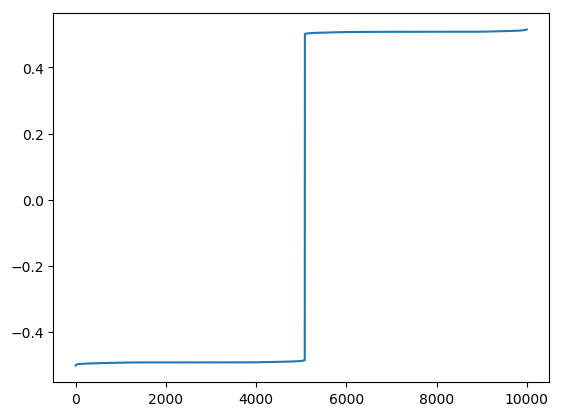

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x129af0950>

In [34]:
#plot(sort(gradient_root[1,:]))
p = sortperm(gradient_root[1,:])
plot(gradient_root[1,p])

In [35]:
print("sds")

sds

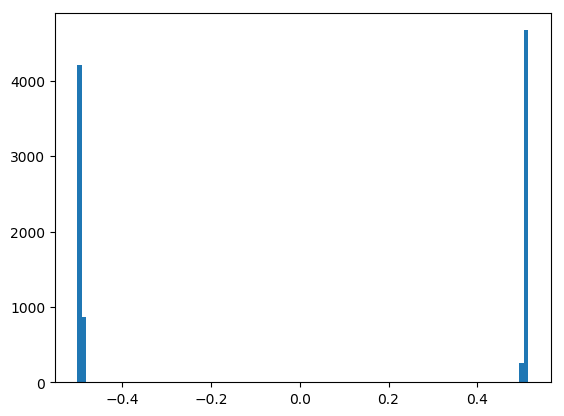

In [36]:
PyPlot.plt[:hist](gradient_root[1,:],bins=100);